In [2]:
import pandas as pd
df = pd.read_csv("son.csv", usecols=["Body", "Labels"])
df.head()

,Body,Labels
0,"\nopen(""http://www.cn1688.net/girls/"")\nclick ...","spam,indecent,"
1,This is a multi-part message in MIME format.,"spam,irrelevant,"
2,I have to say I was surprised about Jacko dang...,"ham,normal,"
3,Hello. We need some posh birds and chaps to us...,"spam,scam,"
4,We sent our photographer into the biker partie...,"spam,indecent,sexual content"


In [3]:
df.shape
df.info()

df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    3600 non-null   object
 1   Labels  3600 non-null   object
dtypes: object(2)
memory usage: 56.4+ KB


63

<Axes: ylabel='Frequency'>

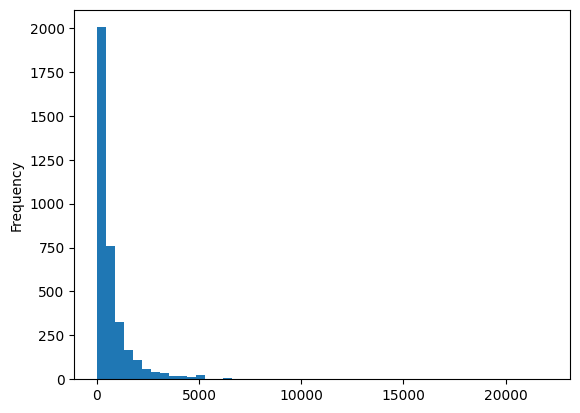

In [4]:
df['Body'].str.len().plot.hist(bins=50)

In [5]:
df['Labels'] = df['Labels'].str.split(',')

In [6]:
genre_counts = [g for gen in df['Labels'] for g in gen]
pd.Series(genre_counts).value_counts()

,count
spam,1916
,1690
ham,1684
normal,1681
scam,1029
pshing,586
irrelevant,502
advertisement,499
indecent,386
investment,272


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

In [8]:
multilabel = MultiLabelBinarizer()

labels = multilabel.fit_transform(df['Labels']).astype('float32')

texts = df['Body'].tolist()

In [9]:
labels
texts[:5]

['\nopen("http://www.cn1688.net/girls/")\nclick here to see more\nï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½',
 'This is a multi-part message in MIME format.',
 'I have to say I was surprised about Jacko dangling that kid of the\nbalcony.\nUsually he just tosses them off...\n\nBoomboom.\n\nD\n\n\nTo unsubscribe from this group, send an email to:\nforteana-unsubscribe@egroups.com\n\n \n\nYour use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/ ',
 'Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r',
 'We sent our photographer into the biker parties. He got pictures of the\nbikes & lifestyle but mostly he got pictures of the biker girls. Some sexy & a lot nude.\n\nWe burned these pictures to a disk and now they are available on disk for you to view on your own computer. The parties are wild and so are the pictures. Over 190 pictures on the disk and the 29.99 price also includes express shipping!!!!\

In [10]:
# Assuming multilabel is your MultiLabelBinarizer or similar encoder
print("Classes in the model:", multilabel.classes_)


Classes in the model: ['' 'advertisement' 'ham' 'health' 'illegal activities' 'indecent'
 'investment' 'irrelevant' 'normal' 'pshing ' 'scam' 'sexual content'
 'spam']


In [11]:
import torch

from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [12]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels,
                                                                    test_size=0.2, random_state=42)

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertTokenizer, AutoTokenizer

# Model ve tokenizer için checkpoint
checkpoint = "bert-base-uncased"

# Tokenizer'ı yükle
tokenizer = BertTokenizer.from_pretrained(checkpoint)

# Modeli yükle
model = BertForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels[0]),  # Etiket sayısını belirleyin
    problem_type="multi_label_classification"  # Çoklu etiket sınıflandırması için
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
labels[0]

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [15]:
# Lets build custom dataset
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': label
    }

In [16]:
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [17]:
# val_dataset[0]

In [18]:
# Multi-Label Classification Evaluation Metrics
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch


def multi_labels_metrics(predictions, labels, threshold=0.3):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions))

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs>=threshold)] = 1
  y_true = labels

  f1 = f1_score(y_true, y_pred, average = 'macro')
  roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
  hamming = hamming_loss(y_true, y_pred)

  metrics = {
      "roc_auc": roc_auc,
      "hamming_loss": hamming,
      "f1": f1
  }

  return metrics

def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

  result = multi_labels_metrics(predictions=preds,
                                labels=p.label_ids)

  return result

In [23]:
from transformers import TrainingArguments, Trainer

import os
os.environ["WANDB_DISABLED"] = "true"


args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir='./results',
    num_train_epochs=5,
    save_steps=1000,
    save_total_limit=5,
    logging_dir='./logs',  # TensorBoard logs directory
    logging_steps=50       # Log every 50 steps
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-23-1c5c091cc260>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
trainer.train()

Step,Training Loss
50,0.401800
100,0.345300
150,0.291300
200,0.298400
250,0.301000
300,0.260600
350,0.267000
400,0.227700
450,0.221600
500,0.190900


TrainOutput(global_step=1800, training_loss=0.1612905968560113, metrics={'train_runtime': 430.7801, 'train_samples_per_second': 33.428, 'train_steps_per_second': 4.178, 'total_flos': 947293349068800.0, 'train_loss': 0.1612905968560113, 'epoch': 5.0})

In [25]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch

def multi_labels_metrics(predictions, labels, threshold=0.3):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    # Binarize predictions based on the threshold
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels

    # Compute F1 score, handling potential undefined metric cases
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # Compute ROC AUC score, handle single-class cases
    try:
        roc_auc = roc_auc_score(y_true, y_pred, average='macro')
    except ValueError:
        roc_auc = None  # Assign None or a default value

    # Compute Hamming loss
    hamming = hamming_loss(y_true, y_pred)

    # Combine metrics into a dictionary
    metrics = {
        "roc_auc": roc_auc,
        "hamming_loss": hamming,
        "f1": f1
    }

    return metrics

def compute_metrics(p: EvalPrediction):
    # Handle predictions and labels
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

    # Pass predictions and labels to multi-label metrics function
    result = multi_labels_metrics(predictions=preds, labels=p.label_ids)

    return result


In [26]:
trainer.evaluate()

{'eval_loss': 0.2663002014160156,
 'eval_roc_auc': 0.8198011385369094,
 'eval_hamming_loss': 0.09775641025641026,
 'eval_f1': 0.6720031707045647,
 'eval_runtime': 6.7675,
 'eval_samples_per_second': 106.391,
 'eval_steps_per_second': 13.299,
 'epoch': 5.0}

In [27]:
trainer.save_model("bert-finetuned-multi-label")
tokenizer.save_pretrained("bert-finetuned-multi-label")

('bert-finetuned-multi-label/tokenizer_config.json',
 'bert-finetuned-multi-label/special_tokens_map.json',
 'bert-finetuned-multi-label/vocab.txt',
 'bert-finetuned-multi-label/added_tokens.json')

In [28]:
import pickle
with open("multi-label-binarizer.pkl", "wb") as f:
  pickle.dump(multilabel, f)

In [29]:
!zip -r bert.zip "/content/bert-finetuned-multi-label"

  adding: content/bert-finetuned-multi-label/ (stored 0%)
  adding: content/bert-finetuned-multi-label/model.safetensors (deflated 7%)
  adding: content/bert-finetuned-multi-label/special_tokens_map.json (deflated 42%)
  adding: content/bert-finetuned-multi-label/config.json (deflated 59%)
  adding: content/bert-finetuned-multi-label/vocab.txt (deflated 53%)
  adding: content/bert-finetuned-multi-label/tokenizer_config.json (deflated 75%)
  adding: content/bert-finetuned-multi-label/training_args.bin (deflated 52%)


In [30]:
import joblib
from sklearn.preprocessing import MultiLabelBinarizer

# Assuming 'multilabel' is your fitted MultiLabelBinarizer
joblib.dump(multilabel, 'multilabel_binarizer.pkl')


['multilabel_binarizer.pkl']

In [ ]:
text = 'We sent our photographer into the biker parties. He got pictures of the bikes & lifestyle but mostly he got pictures of the biker girls. Some sexy & a lot nude. We burned these pictures to a disk and now they are available on disk for you to view on your own computer. The parties are wild and so are the pictures. Over 190 pictures on the disk and the 29.99 price also includes express shipping!!!! These pictures are uncensored so do not request any more information if you are not at least 18. For an order type "order form" in the subject and reply to: To be removed from our mailing type \'nobikers\' in the subject and reply .'


encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)


In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1

multilabel.classes_

multilabel.inverse_transform(preds.reshape(1,-1))

[('advertisement', 'indecent', 'pshing ', 'scam', 'spam')]

In [ ]:
text = '''Subject: Get 80% OFF! Comprehensive Health Check-Up Special

Dear [Recipient],

Your health is our priority! That’s why we’re offering you an exclusive, one-day-only deal:
 Complete blood test and full health check-up for just $19.99!
FREE cholesterol, sugar, and blood pressure screenings.
Online consultation with our certified health specialists.

It’s quick and easy to book! Click here now to claim this incredible offer.

 Hurry, offer expires at midnight!

Remember, regular health checks are essential for a healthy life. Don’t miss this chance to take control of your well-being!

Best regards,
HealthCare Plus
Visit our website | Contact us.'''



encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1

multilabel.classes_

multilabel.inverse_transform(preds.reshape(1,-1))

[('health', 'scam', 'spam')]

In [ ]:
text = '''Subject: You Won't Believe This New Kitchen Gadget!

Hi [Recipient],

Are you tired of messy kitchens and boring meals? Say goodbye to those worries with the RevoSlice 3000—the ultimate tool you never knew you needed!

✅ Slice, dice, and chop ANYTHING in seconds!
✅ Compact, stylish, and dishwasher-safe.
✅ Loved by over 1 million happy customers worldwide!

But wait, there’s more! Order within the next 24 hours and get an additional set of magic peelers—FREE!

👉 Click here to transform your kitchen today!

⚡ Act now—limited stock available!

Don't miss out on this revolutionary gadget. Your kitchen will thank you!

Cheers,
The RevoSlice Team
Visit our website'''

encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)


In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1

multilabel.classes_

multilabel.inverse_transform(preds.reshape(1,-1))

[('advertisement', 'irrelevant', 'spam')]

In [ ]:
text = "Get exclusive access to adult content and connect with like-minded individuals.Naked sex fotos. Girls and Boys kiss."
encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)


In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1

multilabel.classes_

multilabel.inverse_transform(preds.reshape(1,-1))

[('illegal activities', 'indecent', 'sexual content', 'spam')]

In [ ]:
text = '''"Your wrinkles will disappear in 7 days! Try the dermatologist-approved miracle cream now! 🌟"
"End hair loss! 100% effective herbal serum is here. 💇‍♂️ Click to order!"'''
encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1

multilabel.classes_

multilabel.inverse_transform(preds.reshape(1,-1))

[('health', 'scam', 'spam')]

In [ ]:
import pandas as pd
import numpy as np
import torch

# Load your CSV file
input_csv_path = "test.csv"  # Replace with your input file path
output_csv_path = "test_out.csv"  # Replace with your desired output file path

# Load the CSV into a DataFrame
data = pd.read_csv(input_csv_path)

# Assuming your model, tokenizer, and multilabel binarizer are already loaded
# Replace 'text_column' with the column in your CSV that contains the text to predict
text_column = "Body"

# Prepare an empty list to store predictions
predictions = []

# Define sigmoid activation for probabilities
sigmoid = torch.nn.Sigmoid()

# Process each row of the CSV
for index, row in data.iterrows():
    # Tokenize the text with truncation to ensure no input exceeds the model's max length
    text = row[text_column]
    encoding = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)  # Truncating input to 512 tokens
    encoding.to(trainer.model.device)

    # Make prediction
    outputs = trainer.model(**encoding)

    # Apply sigmoid activation directly on the logits (tensor)
    probs = sigmoid(outputs.logits[0].cpu())  # Apply sigmoid on tensor directly

    # Convert to numpy for thresholding
    probs_np = probs.detach().numpy()

    # Threshold for multilabel classification
    preds = np.zeros(probs_np.shape)
    preds[np.where(probs_np >= 0.3)] = 1  # Threshold set to 0.3

    # Decode predicted labels using multilabel.inverse_transform
    decoded_labels = multilabel.inverse_transform(preds.reshape(1, -1))
    predictions.append(decoded_labels[0])  # Append the decoded labels as a list

# Add predictions to the DataFrame
data["predictions"] = [", " + ", ".join(pred) for pred in predictions]  # Join labels with ';'

# Save the new DataFrame with predictions to a CSV file
data.to_csv(output_csv_path, index=False)

print(f"Predictions saved to {output_csv_path}")


Predictions saved to test_out.csv


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

# Load your CSV file containing true and predicted labels
input_csv_path = "test_out.csv"  # Replace with the actual path of your CSV file
data = pd.read_csv(input_csv_path)

# Prepend a comma to every value in the 'Labels' column
data['Labels'] = data['Labels'].apply(lambda x: f", {x}")

# Save the updated DataFrame back to the same file
data.to_csv(input_csv_path, index=False)

# Load your CSV file containing true and predicted labels
input_csv_path = "test_out.csv"  # Replace with the actual path of your CSV file
data = pd.read_csv(input_csv_path)

# Assuming 'Labels1' column contains the true labels and 'predictions1' column contains the predicted labels
true_labels = data['Labels']  # Column with true labels
predicted_labels = data['predictions']  # Column with predicted labels

# Split the true and predicted labels by commas and strip spaces, convert them to sets
y_true = true_labels.apply(lambda x: set(label.strip() for label in x.split(',')))  # Remove spaces and use sets to ignore order
y_pred = predicted_labels.apply(lambda x: set(label.strip() for label in x.split(',')))  # Remove spaces and use sets to ignore order

# Use MultiLabelBinarizer to transform labels for classification report
mlb = MultiLabelBinarizer()
y_true_bin = mlb.fit_transform(y_true)
y_pred_bin = mlb.transform(y_pred)

# Generate classification report
report = classification_report(y_true_bin, y_pred_bin, target_names=mlb.classes_)
print("Classification Report:")
print(report)

# Calculate accuracy for each label separately
accuracies = {}
for idx, label in enumerate(mlb.classes_):
    true_for_label = y_true_bin[:, idx]
    pred_for_label = y_pred_bin[:, idx]
    accuracy_for_label = (true_for_label == pred_for_label).mean()  # Compute accuracy for this label
    accuracies[label] = accuracy_for_label

# Print the accuracy for each label
print("\nAccuracy for each label:")
for label, accuracy in accuracies.items():
    print(f"Accuracy for '{label}': {accuracy * 100:.2f}%")


Classification Report:
                    precision    recall  f1-score   support

                         1.00      1.00      1.00       299
     advertisement       0.57      0.52      0.55        44
               ham       0.97      0.95      0.96       121
            health       0.76      0.89      0.82        38
illegal activities       0.24      0.43      0.31        14
          indecent       0.54      0.68      0.60        28
        investment       0.21      0.86      0.34         7
        irrelevant       0.59      0.52      0.55        44
            normal       0.96      0.95      0.95       120
            pshing       0.70      0.60      0.65        63
              scam       0.76      0.86      0.81       106
    sexual content       0.40      0.67      0.50        12
              spam       0.87      0.97      0.92       160

         micro avg       0.83      0.88      0.86      1056
         macro avg       0.66      0.76      0.69      1056
      weighted 